# Analyzing FAANG stock portfolio for risk and return

The goal of this project is build an effective portfolio comprising FAANG stocks – Facebook (Meta), Apple, Amazon, Netflix, and Google. Your goal is to maximize returns while mitigating risk.

In this project, find the optimal allocation to the FAANG stocks based on historical stock price data spanning the years 2020-2023. The dataset is stored in the `faang_stocks.csv` file. For each trading day, it contains the close prices of the five tech companies.

In [217]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
from pypfopt.efficient_frontier import EfficientCVaR
from scipy.stats import norm, t, lognorm, skewnorm, kstest
import scipy.stats as stats

In [2]:
# Loading data
stock_prices_df = pd.read_csv("faang_stocks.csv", index_col="Date")

# Changing the index to a datetime type allows for easier filtering and plotting.
stock_prices_df.index = pd.to_datetime(stock_prices_df.index)
stock_prices_df

C:\Users\Asus\AppData\Local\Temp\ipykernel_24792\1157053259.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2020-01-02,75.09,94.90,68.43,209.78,329.81
2020-01-03,74.36,93.75,68.08,208.67,325.90
2020-01-06,74.95,95.14,69.89,212.60,335.83
2020-01-07,74.60,95.34,69.76,213.06,330.75
2020-01-08,75.80,94.60,70.25,215.22,339.26
...,...,...,...,...,...
2023-12-22,193.60,153.42,141.49,353.39,486.76
2023-12-26,193.05,153.41,141.52,354.83,491.19
2023-12-27,193.15,153.34,140.37,357.83,491.79


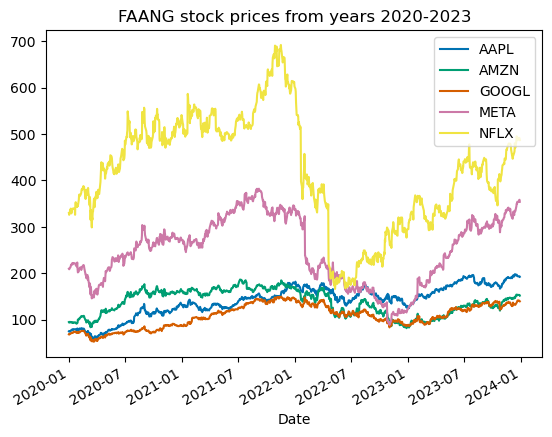

In [3]:
# Setting the plotting style to be colorblind-friendly
plt.style.use("seaborn-colorblind")

# Plotting the stock prices
stock_prices_df.plot(title="FAANG stock prices from years 2020-2023");

### Evaluating the benchmark portfolio

In [15]:
weights = 5 * [0.2] # Assuming an equal-weighted portfolio
stock_returns = stock_prices_df.pct_change().dropna() # Return daily percentual change for each stock
stock_returns.head()

,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2020-01-03,-0.009722,-0.012118,-0.005115,-0.005291,-0.011855
2020-01-06,0.007934,0.014827,0.026586,0.018834,0.030469
2020-01-07,-0.004670,0.002102,-0.001860,0.002164,-0.015127
2020-01-08,0.016086,-0.007762,0.007024,0.010138,0.025729
2020-01-09,0.021240,0.004757,0.010534,0.014311,-0.010611


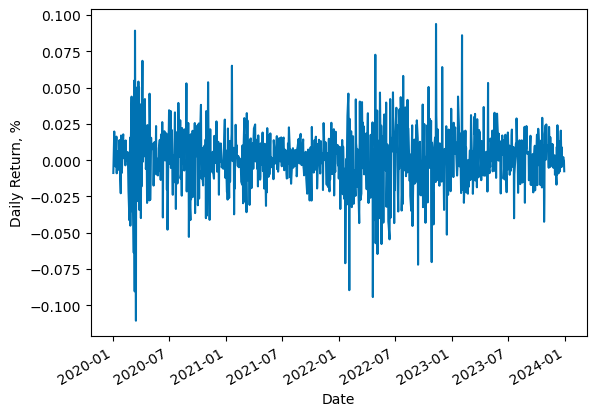

In [16]:
# Computing daily portfolio returns
portfolio_returns = stock_returns.dot(weights)
portfolio_returns.plot().set_ylabel("Daily Return, %")
plt.show()

In [17]:
# Expected Portfolio return
benchmark_exp_return = portfolio_returns.mean()
print("Expected Return = ",benchmark_exp_return)

# Standard Deviation of the Portfolio return
benchmark_std_return = portfolio_returns.std()
print("Standard Deviation = ",benchmark_std_return)

Expected Return =  0.0009366970530650011
Standard Deviation =  0.0205896932683983


In [18]:
# Annualized Sharpe ratio assuming 0% risk-free rate
benchmark_sharpe_ratio = benchmark_exp_return/benchmark_std_return * np.sqrt(252) # trading days in a year
print("Annualized Sharpe Ratio = ", benchmark_sharpe_ratio)

Annualized Sharpe Ratio =  0.7221868020795007


### Loss Distribution
Find which distribution represents better the data

In [216]:
# Extract Portfolio Losses
portfolio_losses = - pd.DataFrame(portfolio_returns).dropna()[0]
portfolio_losses.head()

Date
2020-01-03    0.008820
2020-01-06   -0.019730
2020-01-07    0.003478
2020-01-08   -0.010243
2020-01-09   -0.008046
Name: 0, dtype: float64

In [218]:
# Fit different distributions to the data
distributions = {
    'Normal': stats.norm,
    'LogNormal': stats.lognorm,
    'Student\'s t': stats.t,
    'SkewNormal': stats.skewnorm
}

# Dictionary to store fitted parameters and log-likelihood
fit_results = {}

for name, distribution in distributions.items():
    try:
        if name == 'LogNormal':
            # Filter out non-positive values for LogNormal distribution
            positive_losses = portfolio_losses[portfolio_losses > 0]
            if len(positive_losses) > 0:
                shape, loc, scale = distribution.fit(positive_losses, floc=0)  # force location to be 0
                log_likelihood = np.sum(distribution.logpdf(positive_losses, shape, loc, scale))
                fit_results[name] = {'params': (shape, loc, scale), 'log_likelihood': log_likelihood}
            else:
                print("No positive values for fitting LogNormal distribution.")
        elif name == 'Student\'s t':
            # Fit Student's t distribution
            df, loc, scale = distribution.fit(portfolio_losses)
            log_likelihood = np.sum(distribution.logpdf(portfolio_losses, df, loc, scale))
            fit_results[name] = {'params': (df, loc, scale), 'log_likelihood': log_likelihood}
        elif name == 'SkewNormal':
            # Fit SkewNormal distribution
            a, loc, scale = distribution.fit(portfolio_losses)
            log_likelihood = np.sum(distribution.logpdf(portfolio_losses, a, loc, scale))
            fit_results[name] = {'params': (a, loc, scale), 'log_likelihood': log_likelihood}
        else:
            # Fit Normal distribution
            loc, scale = distribution.fit(portfolio_losses)
            log_likelihood = np.sum(distribution.logpdf(portfolio_losses, loc, scale))
            fit_results[name] = {'params': (loc, scale), 'log_likelihood': log_likelihood}
    except Exception as e:
        print(f"Could not fit {name} distribution: {e}")

# Compare the fitted distributions
fit_results

{'Normal': {'params': (-0.0009366970530650011, 0.020579447090471725),
  'log_likelihood': 2476.8465014950907},
 'LogNormal': {'params': (1.2161667840499644, 0.0, 0.009267621496619655),
  'log_likelihood': 1355.4310331183558},
 "Student's t": {'params': (3.6387470946917615,
   -0.0015951854499430226,
   0.014455008524801041),
  'log_likelihood': 2540.4282458874013},
 'SkewNormal': {'params': (1.0955784361788243,
   -0.01579331642429209,
   0.025381637725465547),
  'log_likelihood': 2482.9307067326517}}

Best fitting distribution: Student's t
Parameters: (3.6387470946917615, -0.0015951854499430226, 0.014455008524801041)


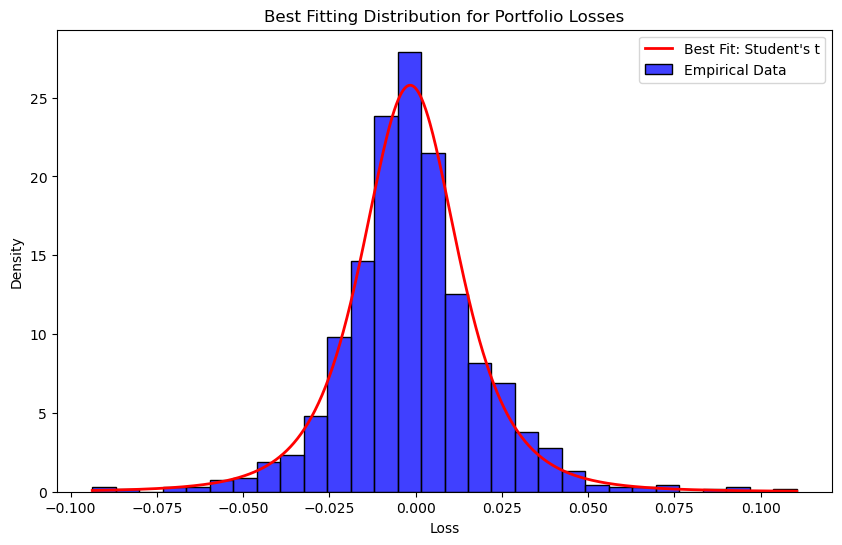

In [219]:
# Identify the distribution with the highest log-likelihood
best_fit = max(fit_results, key=lambda x: fit_results[x]['log_likelihood'])
best_distribution = fit_results[best_fit]
best_params = best_distribution['params']

# Print the best fitting distribution and its parameters
print(f"Best fitting distribution: {best_fit}")
print(f"Parameters: {best_params}")

# Plot the empirical data
plt.figure(figsize=(10, 6))
sns.histplot(portfolio_losses, bins=30, kde=False, color='blue', label='Empirical Data', stat='density')

# Generate data from the best fitting distribution
x = np.linspace(min(portfolio_losses), max(portfolio_losses), 1000)
if best_fit == 'Normal':
    y = stats.norm.pdf(x, *best_params)
elif best_fit == 'LogNormal':
    y = stats.lognorm.pdf(x, *best_params)
elif best_fit == 'Student\'s t':
    y = stats.t.pdf(x, *best_params)
elif best_fit == 'SkewNormal':
    y = stats.skewnorm.pdf(x, *best_params)

# Plot the fitted distribution
plt.plot(x, y, 'r-', lw=2, label=f'Best Fit: {best_fit}')
plt.title('Best Fitting Distribution for Portfolio Losses')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.legend()
plt.show()


Student's t distribution will be use to estimate the losses

## Portfolio Optimization

### MPT: Minimum Volatility Portfolio

In [19]:
# Annualized expected returns
avg_returns = expected_returns.mean_historical_return(stock_prices_df,frequency= 252,compounding=False)
avg_returns

AAPL     0.292454
AMZN     0.188956
GOOGL    0.235250
META     0.242660
NFLX     0.220919
dtype: float64

In [20]:
# Sample Covariance of Stock Returns
sample_cov = stock_returns.cov() * 252
sample_cov

,AAPL,AMZN,GOOGL,META,NFLX
AAPL,0.112683,0.078926,0.077773,0.095367,0.077774
AMZN,0.078926,0.142040,0.083945,0.108089,0.101851
GOOGL,0.077773,0.083945,0.112423,0.106969,0.076233
META,0.095367,0.108089,0.106969,0.218838,0.116967
NFLX,0.077774,0.101851,0.076233,0.116967,0.237020


In [37]:
# Initialize the Crtical Line Algorithm object
efficient_portfolio = CLA(avg_returns, cov_mat)

# Find the minimum volatility portfolio weights
min_vol_weights = pd.Series(efficient_portfolio.min_volatility())
min_vol_weights

AAPL     0.398420
AMZN     0.149108
GOOGL    0.382898
META     0.000000
NFLX     0.069574
dtype: float64


##### Risk and Return Metrics

In [169]:
min_vol_return = stock_returns.dot(min_vol_weights)
min_vol_losses = - min_vol_return

In [170]:
# t distribution for VaR and CVaR 95%
p = t.fit(min_vol_losses)

# Compute the 99% VaR array using the rolling window parameters
min_vol_VaR_95 = t.ppf(0.95, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
min_vol_tail_loss = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = min_vol_VaR_95 )
min_vol_CVaR_95 = (1 / (1 - 0.99)) * min_vol_tail_loss

In [171]:
# Sharpe Ratio
min_vol_mu = min_vol_return.mean()
min_vol_std = min_vol_return.std()

min_vol_sharpe = min_vol_mu/min_vol_std *np.sqrt(252)

min_vol_mu*252

0.25014131804685524

In [172]:
# Volatility, Variance, and Return
min_vol_exp_return = ret[-1]
min_vol_var = np.transpose(min_vol_weights) @ cov_mat @ min_vol_weights
min_portfolio_vol =np.sqrt(min_vol_var)

print("Minimum Volatility Portfolio:")
print("Variance = ", min_vol_var)
print("Volatility = ", min_portfolio_vol)
print("Expected Return = ", min_vol_exp_return)
print("VaR 95% = ", min_vol_VaR_95)
print("CVaR 95% = ", min_vol_CVaR_95)
print("Sharpe Ratio = ", min_vol_sharpe)

Minimum Volatility Portfolio:
Variance =  0.09185365014721536
Volatility =  0.3030736711547464
Expected Return =  0.2501413180468552
VaR 95% =  0.02812001266741248
CVaR 95% =  0.21304862112545883
Sharpe Ratio =  0.825348229998954


### Tangency Portfolio
Maximazing Sharpe Ratio

In [173]:
# Create a new instance of EfficientFrontier
efficient_frontier = EfficientFrontier(avg_returns, cov_mat)

# Calculate the max Sharpe ratio weights
ms_portfolio = pd.Series(efficient_frontier.max_sharpe(risk_free_rate=0))
ms_portfolio

AAPL     0.787440
AMZN     0.000000
GOOGL    0.199698
META     0.000000
NFLX     0.012861
dtype: float64

In [174]:
ms_portfolio_sharpe= efficient_frontier.portfolio_performance(risk_free_rate=0, verbose = True)
ms_portfolio_sharpe 

Expected annual return: 28.0%
Annual volatility: 31.8%
Sharpe Ratio: 0.88


(0.28011064218819304, 0.3175206228163092, 0.8821809421501468)

#### Risk and Return Metrics

In [175]:
ms_return = stock_returns.dot(ms_portfolio)
ms_losses = - ms_return

In [176]:
# t distribution for VaR and CVaR 95%
p = t.fit(ms_losses)

# Compute the 99% VaR array using the rolling window parameters
ms_VaR_95 = t.ppf(0.95, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
ms_tail_loss = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = ms_VaR_95 )
ms_CVaR_95 = (1 / (1 - 0.99)) * ms_tail_loss

In [177]:
# Sharpe Ratio
ms_sharpe = ms_portfolio_sharpe[2]

In [178]:
# Volatility, Variance, and Return
ms_exp_return = ms_portfolio_sharpe[0]
ms_vol = ms_portfolio_sharpe[1]
ms_var = ms_vol**2

print("Maximum Sharpe Ratio Portfolio:", ms_vol)
print("Variance = ", ms_var)
print("Volatility = ", min_portfolio_vol)
print("Expected Return = ", ms_exp_return)
print("VaR 95% = ", ms_VaR_95)
print("CVaR 95% = ", ms_CVaR_95)
print("Sharpe Ratio = ", ms_sharpe)

Minimum Volatility Portfolio: 0.3175206228163092
Variance =  0.1008193459136569
Volatility =  0.3030736711547464
Expected Return =  0.28011064218819304
VaR 95% =  0.029110661118002576
CVaR 95% =  0.22309350949675621
Sharpe Ratio =  0.8821809421501468


### Minimum CVaR Portfolio

In [179]:
ec = EfficientCVaR(None, stock_returns)
min_cvar_weights =  ec.min_cvar()

In [180]:
names = {0: 'AAPL', 1: 'AMZN', 2: 'GOOGL', 3: 'META', 4: 'NFLX'}
min_cvar_weights = pd.Series({ names[i] : min_cvar_weights[i] for i in min_cvar_weights})
min_cvar_weights

AAPL     5.582738e-01
AMZN     1.030059e-01
GOOGL    2.742055e-01
META     4.729000e-12
NFLX     6.451487e-02
dtype: float64

#### Risk and Return Metrics

In [181]:
min_cvar_return = stock_returns.dot(min_cvar_weights)
min_cvar_losses = - min_cvar_return

In [182]:
# t distribution for VaR and CVaR 95%
p = t.fit(min_cvar_losses)

# Compute the 99% VaR array using the rolling window parameters
min_cvar_VaR_95 = t.ppf(0.95, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
min_cvar_tail_loss = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = min_cvar_VaR_95 )
min_cvar_CVaR_95 = (1 / (1 - 0.99)) * min_var_tail_loss

In [207]:
# Sharpe Ratio
min_cvar_mu = min_cvar_return.mean()
min_cvar_std = min_cvar_return.std()

min_cvar_sharpe = min_cvar_mu/min_cvar_std *np.sqrt(252)
min_cvar_mu * 252

0.261492456724812

In [208]:
# Volatility, Variance, and Return
min_cvar_exp_return = min_cvar_mu * 252
min_cvar_cov = stock_returns.cov() * 252
min_cvar_var = np.transpose(min_cvar_weights) @ min_cvar_cov @ min_cvar_weights
min_cvar_vol =np.sqrt(min_cvar_var)

print("Minimum CVaR Portfolio:")
print("Variance = ", min_cvar_var)
print("Volatility = ", min_cvar_vol)
print("Expected Return = ", min_cvar_exp_return)
print("VaR 95% = ", min_cvar_VaR_95)
print("CVaR 95% = ", min_cvar_CVaR_95)
print("Sharpe Ratio = ", min_cvar_sharpe)


Minimum CVaR Portfolio:
Variance =  0.09335013079607835
Volatility =  0.3055325363951904
Expected Return =  0.261492456724812
VaR 95% =  0.02825924568773925
CVaR 95% =  0.21304862112545883
Sharpe Ratio =  0.8558579711673823


### Porfolios Comparison

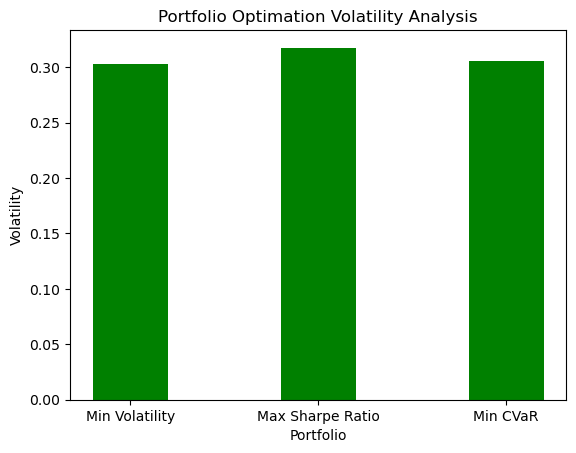

In [198]:
vol_data = {
            "Min Volatility": min_portfolio_vol,
            "Max Sharpe Ratio": ms_vol,
            "Min CVaR": min_cvar_vol
}
vol_port = list(vol_data.keys())
vol_values = list(vol_data.values())

# creating the bar plot
plt.bar(vol_port, vol_values, color ='green', 
        width = 0.4)

plt.xlabel("Portfolio")
plt.ylabel("Volatility")
plt.title("Portfolio Optimation Volatility Analysis")
plt.show()

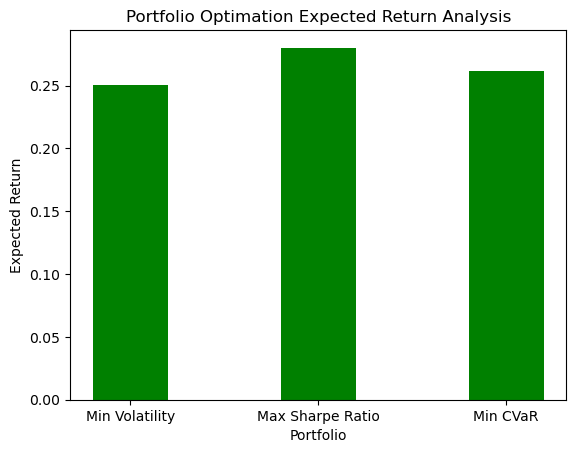

In [209]:
ret_data = {
            "Min Volatility": min_vol_exp_return,
            "Max Sharpe Ratio": ms_exp_return,
            "Min CVaR": min_cvar_exp_return
}
ret_port = list(ret_data.keys())
ret_values = list(ret_data.values())

# creating the bar plot
plt.bar(ret_port, ret_values, color ='green', 
        width = 0.4)

plt.xlabel("Portfolio")
plt.ylabel("Expected Return")
plt.title("Portfolio Optimation Expected Return Analysis")
plt.show()

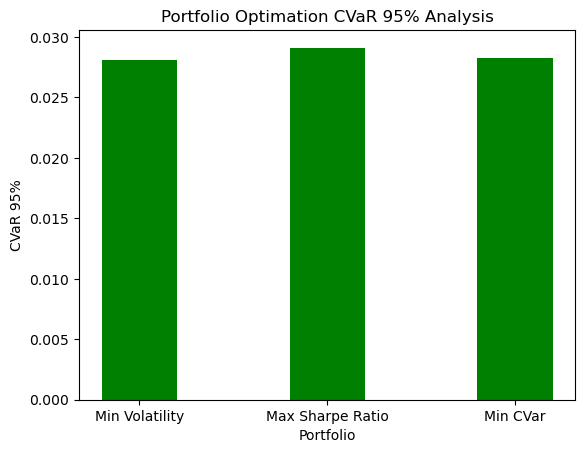

In [200]:
cvar_data = {
            "Min Volatility": min_vol_CVaR_95,
            "Max Sharpe Ratio": ms_CVaR_95,
            "Min CVaR": min_cvar_CVaR_95
}

cvar_port = list(cvar_data.keys())
cvar_values = list(cvar_data.values())

# creating the bar plot

plt.bar(var_port, var_values, color ='green', 
        width = 0.4, label ='CVaR 95%')

plt.xlabel("Portfolio")
plt.ylabel("CVaR 95%")
plt.title("Portfolio Optimation CVaR 95% Analysis")
plt.show()


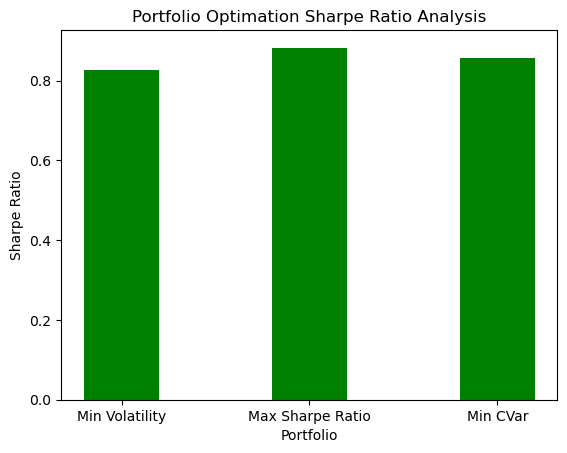

In [201]:
sharpe_data = {
            "Min Volatility": min_vol_sharpe,
            "Max Sharpe Ratio": ms_sharpe,
            "Min CVar": min_cvar_sharpe
}

sharpe_port = list(sharpe_data.keys())
sharpe_values = list(sharpe_data.values())

# creating the bar plot

plt.bar(sharpe_port, sharpe_values, color ='green', 
        width = 0.4)

plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.title("Portfolio Optimation Sharpe Ratio Analysis")
plt.show()

Based on the portfolio's risk and return metrics, the decision between the portfolio depends on investor's risk tolerance shown below:
* Higher risk and expected return: Tangency Portfolio
* Lower risk and expected return: Minimum CVaR Portfolio